In [ ]:
# libs
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as img
from IPython.display import clear_output
from matplotlib import cm

import random
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split


import time
from tqdm import tqdm
from tqdm.notebook import trange

from PIL import Image
from skimage.transform import resize
from skimage import transform

warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# func

def im_loader_to_matrix(df: pd.DataFrame):
    matricies_of_images = list()
    for i, s in zip(range(df.shape[0]+1), tqdm(range(df.shape[0]))):
        image = df['image'].iloc[i]
        image = requests.get(image).content
        image = plt.imread(io.BytesIO(image), format='JPG')
        matricies_of_images.append(image)
    
    df['image_matricies'] = matricies_of_images


def print_worktime(start):
    
    duration = time.time() - start
    duration = round(duration / 60, 3)
    
    print(f"Код отработал за: {duration} минут")


# losses to minimize

def compute_loss(prediction, reference):
    """
    Расчет MSE
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ 
    Расчет MAE
    """
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()


def normaliser(img: np.array):

  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  img_tr = transform(img)
  mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

  transform_norm = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean, std)
  ])

  img_normalized = transform_norm(img)

  return img_normalized

# Подготовка трейн датасета




In [ ]:
labels = np.load('drive/MyDrive/labels_hands.npy', allow_pickle=True)
images = np.load('drive/MyDrive/images_hands.npy', allow_pickle=True)

im_list = [resize(torch.as_tensor(im, dtype=torch.float32), (224, 224)) for im in images]
label_list = [torch.as_tensor(l-1, dtype=torch.float32) for l in labels]

In [ ]:
len(label_list)

819

In [ ]:
type(im_list)

list

In [ ]:
type(label_list[0])

torch.Tensor

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(im_list, label_list, test_size=0.2, random_state=42)

print("Train size = ", len(X_train))
print("Validation size = ", len(X_test))

Train size =  655
Validation size =  164


In [ ]:
# удаляем фото, несоответствующие размерности
X_test = [photo for photo in X_test if photo.shape == (224, 224, 3)]
X_train = [photo for photo in X_train if photo.shape == (224, 224, 3)]

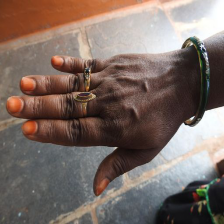

In [ ]:
result = Image.fromarray(np.array(X_train[0]).astype(np.uint8))
result.convert('RGB')

# Собственная модель

### Нормализация пикселей изображения

Text(0.5, 1.0, 'Распределение пикселей')

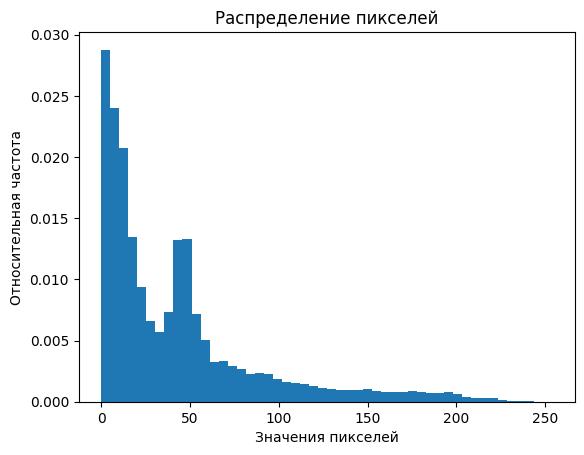

In [ ]:
img_np = np.array(X_train[100])
 
# plot the pixel values
plt.hist(img_np.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

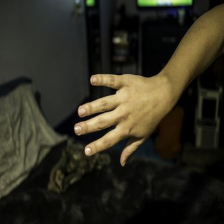

In [ ]:
result = Image.fromarray(np.array(X_train[100]).astype(np.uint8))
result.convert('RGB')

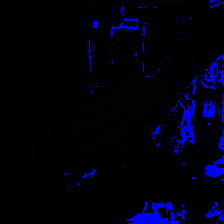

In [ ]:
img_normalized = normaliser(X_train[100])
img_normalized = np.array(img_normalized)
img_normalized_tr = img_normalized.transpose(1, 2, 0)
result = Image.fromarray(np.array(img_normalized_tr).astype(np.uint8))
result.convert('RGB')

Text(0.5, 1.0, 'Распределение пикселей')

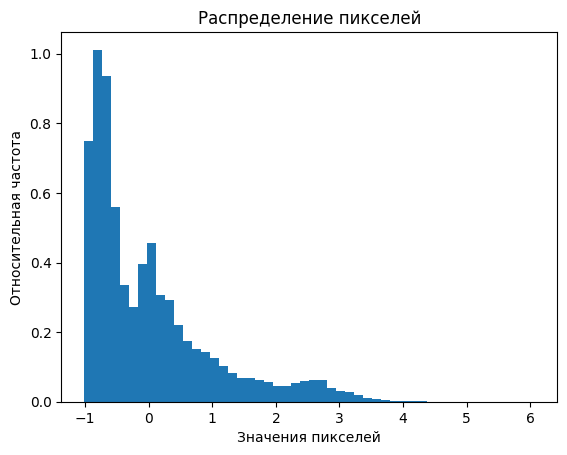

In [ ]:
# img_np = np.array(X_train[0])
 
# plot the pixel values
plt.hist(img_normalized.ravel(), bins=50, density=True)
plt.xlabel("Значения пикселей")
plt.ylabel("Относительная частота")
plt.title("Распределение пикселей")

# Обучение CNN

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.BatchNorm2d(20),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2), 
    nn.Flatten(),
    nn.Linear(3380, 3000),
    nn.ReLU(),
    nn.Linear(3000, 2500),
    nn.ReLU(),
    nn.Linear(2500, 2000),
    nn.Tanh(),
    nn.Linear(2000, 1500),
    nn.ReLU(),
    nn.Linear(1500, 1000),
    nn.Tanh(),
    nn.Linear(1000, 500), 
    nn.ReLU(),
    nn.Linear(500, 100),
    nn.Linear(100, 10),
    nn.Dropout(0.3)      
)

opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# opt = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=20)

In [ ]:
train_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.ColorJitter(),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

In [ ]:
dataset = [[i,j] for i, j in zip(im_list, label_list) if i.shape == (224, 224, 3)]

train_set, val_set = torch.utils.data.random_split(
    dataset, 
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)

train_set = [[torch.transpose(train_transforms(pic[0]), 2,1), pic[1]] for pic in train_set]
val_set = [[torch.transpose(test_transforms(pic[0]), 2,1), pic[1]] for pic in val_set]

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=40, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=40, shuffle=False)

In [ ]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# loss_func = nn.HuberLoss(delta=1.0)
# loss_func = compute_loss
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total_acc_train = 0
    total_loss_train = 0
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in tqdm(train_dataloader):
        # train on batch
        # x_train = train_transforms(np.array(x_train))
        # x_train = normaliser(x_train)
        
        # x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = model(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        outputs = torch.squeeze(outputs, 0)
        loss = F.cross_entropy(outputs, y_train.long())
        loss.backward()
        opt.step()
        opt.zero_grad()
        # _, preds = torch.max(outputs, 0) # taking the highest value of prediction.
        running_loss += loss.item()
        acc = (outputs.argmax(dim=1) == y_train).sum().item()
        total_acc_train += acc
        # running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    total_acc_val = 0
    total_loss_val = 0
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          # x_val = test_transforms(x_val)
          # x_val = torch.reshape(x_val,(50,3, 32, 32))
          # y_val = y_val
          y_out = model(x_val)
          y_out = torch.squeeze(y_out, 0)
          val_loss = F.cross_entropy(y_out, y_val.long())
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 0)
          val_running_loss += val_loss.item()
          # val_running_corrects += torch.sum(y_pred == y_val.data)
          acc = (y_out.argmax(dim=1) == y_val).sum().item()
          total_acc_val += acc
    scheduler.step()

    epoch_loss = running_loss/len(X_train) # loss per epoch
    # epoch_acc = running_corrects.float()/ len(X_train) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(total_acc_train / len(train_set))
    
    val_epoch_loss = val_running_loss/len(X_test)
    # val_epoch_acc = val_running_corrects.float()/len(X_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(total_acc_val / len(val_set))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, total_acc_train / len(train_set)))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, total_acc_val / len(val_set)))

100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Epoch 1 of 100 took 4.853s
epoch : 1
training loss: 0.0598, acc 0.0992 
validation loss: 0.0702, validation acc 0.0732 


100%|██████████| 5/5 [00:00<00:00, 17.76it/s]


Epoch 2 of 100 took 4.128s
epoch : 2
training loss: 0.0597, acc 0.1069 
validation loss: 0.0703, validation acc 0.0732 


100%|██████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 3 of 100 took 3.867s
epoch : 3
training loss: 0.0598, acc 0.0977 
validation loss: 0.0704, validation acc 0.1037 


100%|██████████| 5/5 [00:00<00:00, 14.39it/s]


Epoch 4 of 100 took 5.001s
epoch : 4
training loss: 0.0597, acc 0.1115 
validation loss: 0.0705, validation acc 0.0732 


100%|██████████| 5/5 [00:00<00:00, 14.45it/s]


Epoch 5 of 100 took 3.774s
epoch : 5
training loss: 0.0597, acc 0.1099 
validation loss: 0.0706, validation acc 0.0854 


100%|██████████| 5/5 [00:00<00:00, 15.34it/s]


Epoch 6 of 100 took 3.806s
epoch : 6
training loss: 0.0596, acc 0.1053 
validation loss: 0.0706, validation acc 0.0976 


100%|██████████| 5/5 [00:00<00:00, 15.67it/s]


Epoch 7 of 100 took 5.023s
epoch : 7
training loss: 0.0595, acc 0.1420 
validation loss: 0.0706, validation acc 0.1037 


100%|██████████| 5/5 [00:00<00:00, 14.64it/s]


Epoch 8 of 100 took 3.997s
epoch : 8
training loss: 0.0592, acc 0.1603 
validation loss: 0.0709, validation acc 0.1037 


100%|██████████| 5/5 [00:00<00:00, 16.70it/s]


Epoch 9 of 100 took 4.033s
epoch : 9
training loss: 0.0586, acc 0.1481 
validation loss: 0.0701, validation acc 0.1098 


100%|██████████| 5/5 [00:00<00:00, 15.03it/s]


Epoch 10 of 100 took 4.978s
epoch : 10
training loss: 0.0581, acc 0.1527 
validation loss: 0.0721, validation acc 0.1159 


100%|██████████| 5/5 [00:00<00:00, 14.78it/s]


Epoch 11 of 100 took 3.996s
epoch : 11
training loss: 0.0575, acc 0.1695 
validation loss: 0.0749, validation acc 0.1037 


100%|██████████| 5/5 [00:00<00:00, 14.58it/s]


Epoch 12 of 100 took 4.182s
epoch : 12
training loss: 0.0572, acc 0.1496 
validation loss: 0.0712, validation acc 0.0976 


100%|██████████| 5/5 [00:00<00:00, 17.43it/s]


Epoch 13 of 100 took 5.098s
epoch : 13
training loss: 0.0566, acc 0.1557 
validation loss: 0.0745, validation acc 0.1220 


100%|██████████| 5/5 [00:00<00:00, 15.15it/s]


Epoch 14 of 100 took 4.271s
epoch : 14
training loss: 0.0564, acc 0.1634 
validation loss: 0.0753, validation acc 0.1037 


100%|██████████| 5/5 [00:00<00:00, 17.80it/s]


Epoch 15 of 100 took 3.879s
epoch : 15
training loss: 0.0562, acc 0.1802 
validation loss: 0.0757, validation acc 0.1220 


100%|██████████| 5/5 [00:00<00:00, 17.10it/s]


Epoch 16 of 100 took 4.825s
epoch : 16
training loss: 0.0559, acc 0.1664 
validation loss: 0.0735, validation acc 0.1402 


100%|██████████| 5/5 [00:00<00:00, 15.36it/s]


Epoch 17 of 100 took 4.245s
epoch : 17
training loss: 0.0557, acc 0.1710 
validation loss: 0.0724, validation acc 0.1463 


100%|██████████| 5/5 [00:00<00:00, 14.96it/s]


Epoch 18 of 100 took 3.943s
epoch : 18
training loss: 0.0564, acc 0.1710 
validation loss: 0.0719, validation acc 0.1951 


100%|██████████| 5/5 [00:00<00:00, 17.13it/s]


Epoch 19 of 100 took 5.178s
epoch : 19
training loss: 0.0555, acc 0.1756 
validation loss: 0.0734, validation acc 0.1524 


100%|██████████| 5/5 [00:00<00:00, 17.33it/s]


Epoch 20 of 100 took 3.683s
epoch : 20
training loss: 0.0544, acc 0.1664 
validation loss: 0.0780, validation acc 0.1524 


100%|██████████| 5/5 [00:00<00:00, 16.52it/s]


Epoch 21 of 100 took 4.013s
epoch : 21
training loss: 0.0527, acc 0.2534 
validation loss: 0.0724, validation acc 0.2073 


100%|██████████| 5/5 [00:00<00:00, 17.53it/s]


Epoch 22 of 100 took 4.986s
epoch : 22
training loss: 0.0519, acc 0.2580 
validation loss: 0.0730, validation acc 0.2195 


100%|██████████| 5/5 [00:00<00:00, 15.03it/s]


Epoch 23 of 100 took 4.347s
epoch : 23
training loss: 0.0514, acc 0.2656 
validation loss: 0.0738, validation acc 0.1890 


100%|██████████| 5/5 [00:00<00:00, 16.83it/s]


Epoch 24 of 100 took 3.903s
epoch : 24
training loss: 0.0511, acc 0.2443 
validation loss: 0.0743, validation acc 0.2012 


100%|██████████| 5/5 [00:00<00:00, 17.26it/s]


Epoch 25 of 100 took 4.874s
epoch : 25
training loss: 0.0503, acc 0.2489 
validation loss: 0.0753, validation acc 0.1951 


100%|██████████| 5/5 [00:00<00:00, 16.97it/s]


Epoch 26 of 100 took 3.847s
epoch : 26
training loss: 0.0503, acc 0.2626 
validation loss: 0.0746, validation acc 0.1341 


100%|██████████| 5/5 [00:00<00:00, 16.47it/s]


Epoch 27 of 100 took 4.041s
epoch : 27
training loss: 0.0490, acc 0.2947 
validation loss: 0.0761, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Epoch 28 of 100 took 5.142s
epoch : 28
training loss: 0.0496, acc 0.2702 
validation loss: 0.0764, validation acc 0.1341 


100%|██████████| 5/5 [00:00<00:00, 17.19it/s]


Epoch 29 of 100 took 3.951s
epoch : 29
training loss: 0.0489, acc 0.2733 
validation loss: 0.0798, validation acc 0.2012 


100%|██████████| 5/5 [00:00<00:00, 17.36it/s]


Epoch 30 of 100 took 4.069s
epoch : 30
training loss: 0.0479, acc 0.2992 
validation loss: 0.0800, validation acc 0.2134 


100%|██████████| 5/5 [00:00<00:00, 16.03it/s]


Epoch 31 of 100 took 5.134s
epoch : 31
training loss: 0.0481, acc 0.2794 
validation loss: 0.0818, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 14.22it/s]


Epoch 32 of 100 took 3.901s
epoch : 32
training loss: 0.0474, acc 0.2916 
validation loss: 0.0833, validation acc 0.1890 


100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


Epoch 33 of 100 took 4.156s
epoch : 33
training loss: 0.0478, acc 0.3008 
validation loss: 0.0831, validation acc 0.2195 


100%|██████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 34 of 100 took 4.887s
epoch : 34
training loss: 0.0469, acc 0.3282 
validation loss: 0.0807, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 17.45it/s]


Epoch 35 of 100 took 3.697s
epoch : 35
training loss: 0.0462, acc 0.3115 
validation loss: 0.0823, validation acc 0.1951 


100%|██████████| 5/5 [00:00<00:00, 17.27it/s]


Epoch 36 of 100 took 3.895s
epoch : 36
training loss: 0.0457, acc 0.3237 
validation loss: 0.0870, validation acc 0.1890 


100%|██████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 37 of 100 took 4.671s
epoch : 37
training loss: 0.0460, acc 0.3221 
validation loss: 0.0839, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 15.50it/s]


Epoch 38 of 100 took 4.085s
epoch : 38
training loss: 0.0454, acc 0.3420 
validation loss: 0.0860, validation acc 0.2378 


100%|██████████| 5/5 [00:00<00:00, 16.86it/s]


Epoch 39 of 100 took 4.195s
epoch : 39
training loss: 0.0454, acc 0.3344 
validation loss: 0.0944, validation acc 0.1159 


100%|██████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 40 of 100 took 4.668s
epoch : 40
training loss: 0.0473, acc 0.2977 
validation loss: 0.0895, validation acc 0.1951 


100%|██████████| 5/5 [00:00<00:00, 14.27it/s]


Epoch 41 of 100 took 4.461s
epoch : 41
training loss: 0.0432, acc 0.3695 
validation loss: 0.0877, validation acc 0.2073 


100%|██████████| 5/5 [00:00<00:00, 16.75it/s]


Epoch 42 of 100 took 3.701s
epoch : 42
training loss: 0.0437, acc 0.4046 
validation loss: 0.0874, validation acc 0.2012 


100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 43 of 100 took 4.004s
epoch : 43
training loss: 0.0441, acc 0.4046 
validation loss: 0.0874, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 17.06it/s]


Epoch 44 of 100 took 4.662s
epoch : 44
training loss: 0.0437, acc 0.3908 
validation loss: 0.0875, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 14.60it/s]


Epoch 45 of 100 took 3.967s
epoch : 45
training loss: 0.0442, acc 0.3893 
validation loss: 0.0878, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


Epoch 46 of 100 took 3.730s
epoch : 46
training loss: 0.0432, acc 0.4198 
validation loss: 0.0882, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 17.12it/s]


Epoch 47 of 100 took 4.962s
epoch : 47
training loss: 0.0437, acc 0.4214 
validation loss: 0.0881, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.11it/s]


Epoch 48 of 100 took 3.720s
epoch : 48
training loss: 0.0433, acc 0.4092 
validation loss: 0.0891, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


Epoch 49 of 100 took 3.862s
epoch : 49
training loss: 0.0427, acc 0.4321 
validation loss: 0.0888, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 17.25it/s]


Epoch 50 of 100 took 4.935s
epoch : 50
training loss: 0.0432, acc 0.4244 
validation loss: 0.0892, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.70it/s]


Epoch 51 of 100 took 3.979s
epoch : 51
training loss: 0.0436, acc 0.4260 
validation loss: 0.0902, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 16.91it/s]


Epoch 52 of 100 took 3.998s
epoch : 52
training loss: 0.0423, acc 0.4595 
validation loss: 0.0901, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 14.94it/s]


Epoch 53 of 100 took 4.891s
epoch : 53
training loss: 0.0432, acc 0.4122 
validation loss: 0.0905, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 14.26it/s]


Epoch 54 of 100 took 4.105s
epoch : 54
training loss: 0.0425, acc 0.4305 
validation loss: 0.0901, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


Epoch 55 of 100 took 3.865s
epoch : 55
training loss: 0.0423, acc 0.4305 
validation loss: 0.0902, validation acc 0.1890 


100%|██████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch 56 of 100 took 4.847s
epoch : 56
training loss: 0.0429, acc 0.4366 
validation loss: 0.0910, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 16.79it/s]


Epoch 57 of 100 took 4.084s
epoch : 57
training loss: 0.0426, acc 0.4443 
validation loss: 0.0908, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.39it/s]


Epoch 58 of 100 took 3.793s
epoch : 58
training loss: 0.0421, acc 0.4458 
validation loss: 0.0915, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 59 of 100 took 4.810s
epoch : 59
training loss: 0.0431, acc 0.4382 
validation loss: 0.0911, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 17.05it/s]


Epoch 60 of 100 took 3.893s
epoch : 60
training loss: 0.0419, acc 0.4611 
validation loss: 0.0915, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 14.49it/s]


Epoch 61 of 100 took 4.243s
epoch : 61
training loss: 0.0424, acc 0.4305 
validation loss: 0.0915, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch 62 of 100 took 5.257s
epoch : 62
training loss: 0.0413, acc 0.4412 
validation loss: 0.0914, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 13.29it/s]


Epoch 63 of 100 took 4.524s
epoch : 63
training loss: 0.0420, acc 0.4504 
validation loss: 0.0911, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 16.23it/s]


Epoch 64 of 100 took 4.162s
epoch : 64
training loss: 0.0425, acc 0.4580 
validation loss: 0.0914, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Epoch 65 of 100 took 5.329s
epoch : 65
training loss: 0.0426, acc 0.4260 
validation loss: 0.0916, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 13.62it/s]


Epoch 66 of 100 took 4.264s
epoch : 66
training loss: 0.0421, acc 0.4443 
validation loss: 0.0919, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 16.03it/s]


Epoch 67 of 100 took 3.944s
epoch : 67
training loss: 0.0423, acc 0.4702 
validation loss: 0.0921, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 14.55it/s]


Epoch 68 of 100 took 5.438s
epoch : 68
training loss: 0.0429, acc 0.4550 
validation loss: 0.0917, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 14.42it/s]


Epoch 69 of 100 took 4.212s
epoch : 69
training loss: 0.0420, acc 0.4550 
validation loss: 0.0915, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Epoch 70 of 100 took 4.001s
epoch : 70
training loss: 0.0427, acc 0.4519 
validation loss: 0.0917, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 17.33it/s]


Epoch 71 of 100 took 5.180s
epoch : 71
training loss: 0.0425, acc 0.4702 
validation loss: 0.0917, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Epoch 72 of 100 took 3.904s
epoch : 72
training loss: 0.0426, acc 0.4427 
validation loss: 0.0917, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 14.24it/s]


Epoch 73 of 100 took 4.070s
epoch : 73
training loss: 0.0425, acc 0.4427 
validation loss: 0.0921, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 13.53it/s]


Epoch 74 of 100 took 5.249s
epoch : 74
training loss: 0.0421, acc 0.4565 
validation loss: 0.0923, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 16.30it/s]


Epoch 75 of 100 took 3.850s
epoch : 75
training loss: 0.0427, acc 0.4534 
validation loss: 0.0918, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 17.39it/s]


Epoch 76 of 100 took 4.011s
epoch : 76
training loss: 0.0423, acc 0.4427 
validation loss: 0.0921, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 77 of 100 took 5.313s
epoch : 77
training loss: 0.0422, acc 0.4489 
validation loss: 0.0922, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 15.16it/s]


Epoch 78 of 100 took 4.197s
epoch : 78
training loss: 0.0417, acc 0.4794 
validation loss: 0.0918, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 14.17it/s]


Epoch 79 of 100 took 4.144s
epoch : 79
training loss: 0.0427, acc 0.4519 
validation loss: 0.0923, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 16.18it/s]


Epoch 80 of 100 took 5.197s
epoch : 80
training loss: 0.0430, acc 0.4580 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 16.72it/s]


Epoch 81 of 100 took 3.745s
epoch : 81
training loss: 0.0430, acc 0.4351 
validation loss: 0.0918, validation acc 0.1768 


100%|██████████| 5/5 [00:00<00:00, 16.63it/s]


Epoch 82 of 100 took 3.734s
epoch : 82
training loss: 0.0429, acc 0.4550 
validation loss: 0.0921, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch 83 of 100 took 5.273s
epoch : 83
training loss: 0.0422, acc 0.4489 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 17.32it/s]


Epoch 84 of 100 took 4.099s
epoch : 84
training loss: 0.0426, acc 0.4565 
validation loss: 0.0920, validation acc 0.1585 


100%|██████████| 5/5 [00:00<00:00, 16.51it/s]


Epoch 85 of 100 took 3.797s
epoch : 85
training loss: 0.0420, acc 0.4779 
validation loss: 0.0920, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 86 of 100 took 4.606s
epoch : 86
training loss: 0.0426, acc 0.4443 
validation loss: 0.0923, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 16.37it/s]


Epoch 87 of 100 took 4.067s
epoch : 87
training loss: 0.0421, acc 0.4534 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 17.03it/s]


Epoch 88 of 100 took 4.048s
epoch : 88
training loss: 0.0422, acc 0.4458 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 89 of 100 took 4.949s
epoch : 89
training loss: 0.0432, acc 0.4565 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 15.35it/s]


Epoch 90 of 100 took 4.557s
epoch : 90
training loss: 0.0433, acc 0.4397 
validation loss: 0.0918, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 17.16it/s]


Epoch 91 of 100 took 3.746s
epoch : 91
training loss: 0.0432, acc 0.4382 
validation loss: 0.0917, validation acc 0.1829 


100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 92 of 100 took 4.492s
epoch : 92
training loss: 0.0414, acc 0.4809 
validation loss: 0.0918, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 16.50it/s]


Epoch 93 of 100 took 4.437s
epoch : 93
training loss: 0.0413, acc 0.4595 
validation loss: 0.0921, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Epoch 94 of 100 took 3.899s
epoch : 94
training loss: 0.0425, acc 0.4565 
validation loss: 0.0924, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 11.22it/s]


Epoch 95 of 100 took 4.184s
epoch : 95
training loss: 0.0428, acc 0.4443 
validation loss: 0.0919, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 17.54it/s]


Epoch 96 of 100 took 4.620s
epoch : 96
training loss: 0.0423, acc 0.4702 
validation loss: 0.0923, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 16.44it/s]


Epoch 97 of 100 took 3.713s
epoch : 97
training loss: 0.0418, acc 0.4458 
validation loss: 0.0922, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 15.14it/s]


Epoch 98 of 100 took 3.748s
epoch : 98
training loss: 0.0421, acc 0.4779 
validation loss: 0.0922, validation acc 0.1707 


100%|██████████| 5/5 [00:00<00:00, 17.05it/s]


Epoch 99 of 100 took 5.129s
epoch : 99
training loss: 0.0420, acc 0.4504 
validation loss: 0.0921, validation acc 0.1646 


100%|██████████| 5/5 [00:00<00:00, 15.08it/s]

Epoch 100 of 100 took 3.896s
epoch : 100
training loss: 0.0417, acc 0.4550 
validation loss: 0.0920, validation acc 0.1646 


In [ ]:
x_demo = test_transforms(X_test[54])
x_demo = torch.reshape(x_demo,(1,3, 32, 32))
# y_val = y_val
y_out = model(x_demo)
y_out = torch.squeeze(y_out, 0)
# val_loss = loss_func(y_out, y_val.long())
# val_loss = compute_loss(y_val, y_out)
_, y_pred = torch.max(y_out, 0)

In [ ]:
y_pred

In [ ]:
Y_test[54]

In [ ]:
val_epoch_acc

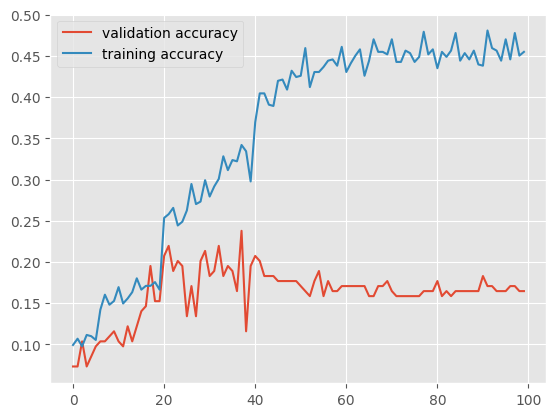

In [ ]:
plt.style.use('ggplot')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.plot(running_corrects_history, label='training accuracy')
plt.legend()

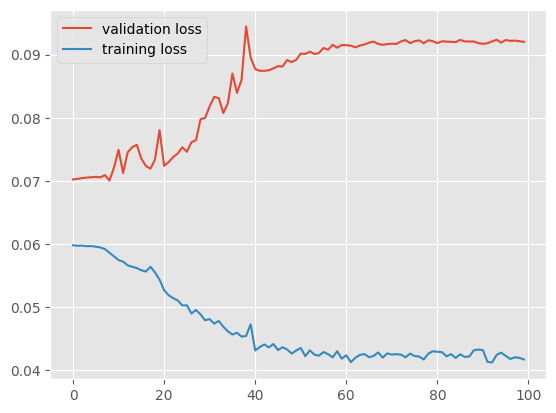

In [ ]:
plt.style.use('ggplot')
plt.plot(val_running_loss_history, label='validation loss')
plt.plot(running_loss_history, label='training loss')

plt.legend()

### fine-tuning

In [ ]:
! pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.5 MB/s eta 0:00:00


In [ ]:

! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.2 MB/s eta 0:00:00


In [ ]:
# import pytorch_lightning as pl
# from torchmetrics.functional import MSE
from torchvision.models import vgg16, resnet152
from torchvision.models.inception import inception_v3

In [ ]:
# import timm

In [ ]:
model_resnet = resnet152(pretrained=True)
model_resnet.fc = nn.Linear(2048, 10)

for param in model_resnet.parameters():
               param.requires_grad = False

opt = torch.optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9)
# opt = torch.optim.Adam(model_resnet.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, gamma=0.1, step_size=20)

In [ ]:
model_resnet.fc

Linear(in_features=2048, out_features=10, bias=True)

In [ ]:
num_epochs = 100
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# loss_func = nn.HuberLoss(delta=1.0)
# loss_func = compute_loss
loss_func = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    total_acc_train = 0
    total_loss_train = 0
    start_time = time.time()
    model_resnet.train(True) # enable dropout / batch_norm training behavior
    for x_train, y_train in tqdm(train_dataloader):
        # train on batch
        # x_train = train_transforms(np.array(x_train))
        # x_train = normaliser(x_train)
        
        # x_train = torch.reshape(x_train,(1,3, 32, 32))
        outputs = model_resnet(x_train)
        # print(outputs)
        # loss = compute_loss(y_train, outputs)
        outputs = torch.squeeze(outputs, 0)
        loss = loss_func(outputs, y_train.long())
        loss.requires_grad = True
        loss.backward()
        opt.step()
        opt.zero_grad()
        # _, preds = torch.max(outputs, 0) # taking the highest value of prediction.
        running_loss += loss.item()
        acc = (outputs.argmax(dim=1) == y_train).sum().item()
        total_acc_train += acc
        # running_corrects += torch.sum(preds == y_train.data)
    # And a full pass over the validation data:
    total_acc_val = 0
    total_loss_val = 0
    model_resnet.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
      for x_val, y_val in tqdm(val_dataloader):
          # x_val = test_transforms(x_val)
          # x_val = torch.reshape(x_val,(50,3, 32, 32))
          # y_val = y_val
          y_out = model_resnet(x_val)
          y_out = torch.squeeze(y_out, 0)
          val_loss = loss_func(y_out, y_val.long())
          # val_loss = compute_loss(y_val, y_out)
          _, y_pred = torch.max(y_out, 0)
          val_running_loss += val_loss.item()
          # val_running_corrects += torch.sum(y_pred == y_val.data)
          acc = (y_out.argmax(dim=1) == y_val).sum().item()
          total_acc_val += acc
    scheduler.step()

    epoch_loss = running_loss/len(X_train) # loss per epoch
    # epoch_acc = running_corrects.float()/ len(X_train) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(total_acc_train / len(train_set))
    
    val_epoch_loss = val_running_loss/len(X_test)
    # val_epoch_acc = val_running_corrects.float()/len(X_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(total_acc_val / len(val_set))
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print('epoch :', (epoch+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, total_acc_train / len(train_set)))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, total_acc_val / len(val_set)))

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 1 of 100 took 14.982s
epoch : 1
training loss: 0.0628, acc 0.0901 
validation loss: 0.0698, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 2 of 100 took 14.829s
epoch : 2
training loss: 0.0633, acc 0.0870 
validation loss: 0.1194, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 3 of 100 took 15.503s
epoch : 3
training loss: 0.0628, acc 0.1008 
validation loss: 0.4631, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 4 of 100 took 14.857s
epoch : 4
training loss: 0.0623, acc 0.1084 
validation loss: 0.6594, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 5 of 100 took 16.236s
epoch : 5
training loss: 0.0626, acc 0.0931 
validation loss: 0.2150, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 6 of 100 took 14.949s
epoch : 6
training loss: 0.0629, acc 0.1099 
validation loss: 0.2079, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 7 of 100 took 14.989s
epoch : 7
training loss: 0.0623, acc 0.1099 
validation loss: 0.4133, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 8 of 100 took 16.709s
epoch : 8
training loss: 0.0625, acc 0.1023 
validation loss: 0.2077, validation acc 0.0854 


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 9 of 100 took 15.132s
epoch : 9
training loss: 0.0630, acc 0.0992 
validation loss: 0.2765, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch 10 of 100 took 15.204s
epoch : 10
training loss: 0.0622, acc 0.0947 
validation loss: 0.3319, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch 11 of 100 took 15.101s
epoch : 11
training loss: 0.0626, acc 0.0931 
validation loss: 0.2475, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 12 of 100 took 15.049s
epoch : 12
training loss: 0.0623, acc 0.1038 
validation loss: 0.2403, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 13 of 100 took 15.488s
epoch : 13
training loss: 0.0628, acc 0.0885 
validation loss: 0.2001, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch 14 of 100 took 15.587s
epoch : 14
training loss: 0.0631, acc 0.0840 
validation loss: 0.1994, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 15 of 100 took 15.660s
epoch : 15
training loss: 0.0629, acc 0.1023 
validation loss: 0.2005, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 16 of 100 took 15.617s
epoch : 16
training loss: 0.0622, acc 0.0962 
validation loss: 0.2168, validation acc 0.1341 


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 17 of 100 took 15.433s
epoch : 17
training loss: 0.0627, acc 0.0992 
validation loss: 0.2770, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 18 of 100 took 15.024s
epoch : 18
training loss: 0.0624, acc 0.1069 
validation loss: 0.4532, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 19 of 100 took 15.184s
epoch : 19
training loss: 0.0621, acc 0.1038 
validation loss: 0.2222, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 20 of 100 took 15.224s
epoch : 20
training loss: 0.0628, acc 0.1053 
validation loss: 0.3896, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 21 of 100 took 15.377s
epoch : 21
training loss: 0.0622, acc 0.1115 
validation loss: 0.2568, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 22 of 100 took 15.120s
epoch : 22
training loss: 0.0626, acc 0.0947 
validation loss: 0.5443, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 23 of 100 took 15.343s
epoch : 23
training loss: 0.0627, acc 0.0962 
validation loss: 0.2760, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 24 of 100 took 15.399s
epoch : 24
training loss: 0.0623, acc 0.0992 
validation loss: 0.2457, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 25 of 100 took 15.353s
epoch : 25
training loss: 0.0623, acc 0.0947 
validation loss: 0.2691, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 26 of 100 took 15.225s
epoch : 26
training loss: 0.0627, acc 0.1038 
validation loss: 0.2286, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 27 of 100 took 15.211s
epoch : 27
training loss: 0.0621, acc 0.1221 
validation loss: 0.2594, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 28 of 100 took 15.305s
epoch : 28
training loss: 0.0624, acc 0.0901 
validation loss: 0.2484, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 29 of 100 took 15.917s
epoch : 29
training loss: 0.0625, acc 0.1023 
validation loss: 0.2762, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 30 of 100 took 16.511s
epoch : 30
training loss: 0.0622, acc 0.0931 
validation loss: 0.3193, validation acc 0.1159 


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch 31 of 100 took 16.949s
epoch : 31
training loss: 0.0627, acc 0.0947 
validation loss: 0.3699, validation acc 0.1463 


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 32 of 100 took 16.185s
epoch : 32
training loss: 0.0628, acc 0.0962 
validation loss: 0.2481, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 33 of 100 took 16.015s
epoch : 33
training loss: 0.0625, acc 0.0992 
validation loss: 0.3083, validation acc 0.0793 


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 34 of 100 took 16.621s
epoch : 34
training loss: 0.0622, acc 0.1038 
validation loss: 0.2957, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 35 of 100 took 15.689s
epoch : 35
training loss: 0.0623, acc 0.1053 
validation loss: 0.2074, validation acc 0.0915 


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 36 of 100 took 15.454s
epoch : 36
training loss: 0.0625, acc 0.1023 
validation loss: 0.2320, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 37 of 100 took 15.984s
epoch : 37
training loss: 0.0623, acc 0.1023 
validation loss: 0.2441, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 38 of 100 took 15.213s
epoch : 38
training loss: 0.0630, acc 0.0870 
validation loss: 0.3348, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 39 of 100 took 15.165s
epoch : 39
training loss: 0.0627, acc 0.1115 
validation loss: 0.3059, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 40 of 100 took 15.349s
epoch : 40
training loss: 0.0622, acc 0.0931 
validation loss: 0.2468, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 41 of 100 took 15.222s
epoch : 41
training loss: 0.0624, acc 0.0855 
validation loss: 0.2626, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 42 of 100 took 15.373s
epoch : 42
training loss: 0.0628, acc 0.0916 
validation loss: 0.3785, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 43 of 100 took 15.354s
epoch : 43
training loss: 0.0629, acc 0.0977 
validation loss: 0.3204, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 44 of 100 took 16.022s
epoch : 44
training loss: 0.0624, acc 0.0824 
validation loss: 0.4032, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 45 of 100 took 16.465s
epoch : 45
training loss: 0.0624, acc 0.0855 
validation loss: 0.3502, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 46 of 100 took 15.481s
epoch : 46
training loss: 0.0624, acc 0.1023 
validation loss: 0.3757, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 47 of 100 took 15.366s
epoch : 47
training loss: 0.0629, acc 0.1115 
validation loss: 0.3487, validation acc 0.1341 


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 48 of 100 took 15.334s
epoch : 48
training loss: 0.0627, acc 0.1053 
validation loss: 0.3893, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch 49 of 100 took 15.402s
epoch : 49
training loss: 0.0627, acc 0.0947 
validation loss: 0.2657, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Epoch 50 of 100 took 15.552s
epoch : 50
training loss: 0.0628, acc 0.0931 
validation loss: 0.3375, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch 51 of 100 took 15.480s
epoch : 51
training loss: 0.0626, acc 0.0931 
validation loss: 0.4200, validation acc 0.1402 


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch 52 of 100 took 15.404s
epoch : 52
training loss: 0.0626, acc 0.1053 
validation loss: 0.2900, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 53 of 100 took 15.444s
epoch : 53
training loss: 0.0630, acc 0.0962 
validation loss: 0.1833, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 54 of 100 took 15.425s
epoch : 54
training loss: 0.0630, acc 0.1069 
validation loss: 0.2689, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 55 of 100 took 15.320s
epoch : 55
training loss: 0.0627, acc 0.0916 
validation loss: 0.3845, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 56 of 100 took 15.307s
epoch : 56
training loss: 0.0628, acc 0.0916 
validation loss: 0.5949, validation acc 0.1341 


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 57 of 100 took 15.223s
epoch : 57
training loss: 0.0624, acc 0.0947 
validation loss: 0.6176, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 58 of 100 took 14.916s
epoch : 58
training loss: 0.0624, acc 0.1008 
validation loss: 0.5772, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 59 of 100 took 15.270s
epoch : 59
training loss: 0.0628, acc 0.1008 
validation loss: 0.3237, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 60 of 100 took 15.532s
epoch : 60
training loss: 0.0621, acc 0.0901 
validation loss: 0.3571, validation acc 0.1341 


100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch 61 of 100 took 15.658s
epoch : 61
training loss: 0.0624, acc 0.1115 
validation loss: 0.2305, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 62 of 100 took 15.540s
epoch : 62
training loss: 0.0624, acc 0.0977 
validation loss: 0.1935, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 63 of 100 took 15.674s
epoch : 63
training loss: 0.0624, acc 0.1130 
validation loss: 0.2230, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch 64 of 100 took 16.467s
epoch : 64
training loss: 0.0629, acc 0.1069 
validation loss: 0.3714, validation acc 0.1280 


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch 65 of 100 took 16.587s
epoch : 65
training loss: 0.0625, acc 0.1008 
validation loss: 0.3720, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 66 of 100 took 16.451s
epoch : 66
training loss: 0.0623, acc 0.1176 
validation loss: 0.2887, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 67 of 100 took 16.371s
epoch : 67
training loss: 0.0622, acc 0.0962 
validation loss: 0.3779, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 68 of 100 took 16.614s
epoch : 68
training loss: 0.0625, acc 0.1115 
validation loss: 0.2729, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch 69 of 100 took 17.667s
epoch : 69
training loss: 0.0626, acc 0.1008 
validation loss: 0.2445, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 70 of 100 took 16.324s
epoch : 70
training loss: 0.0622, acc 0.1145 
validation loss: 0.5291, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 71 of 100 took 16.456s
epoch : 71
training loss: 0.0625, acc 0.0855 
validation loss: 0.3074, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 72 of 100 took 16.466s
epoch : 72
training loss: 0.0628, acc 0.0794 
validation loss: 0.2242, validation acc 0.1037 


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch 73 of 100 took 16.974s
epoch : 73
training loss: 0.0628, acc 0.0977 
validation loss: 0.2901, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch 74 of 100 took 16.778s
epoch : 74
training loss: 0.0626, acc 0.1008 
validation loss: 0.2564, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 75 of 100 took 16.002s
epoch : 75
training loss: 0.0627, acc 0.0947 
validation loss: 0.2386, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 76 of 100 took 15.967s
epoch : 76
training loss: 0.0627, acc 0.0947 
validation loss: 0.3824, validation acc 0.1037 


100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 77 of 100 took 15.986s
epoch : 77
training loss: 0.0623, acc 0.0962 
validation loss: 0.4607, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch 78 of 100 took 16.952s
epoch : 78
training loss: 0.0630, acc 0.0794 
validation loss: 0.2871, validation acc 0.0793 


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 79 of 100 took 16.386s
epoch : 79
training loss: 0.0626, acc 0.0962 
validation loss: 0.2788, validation acc 0.0854 


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 80 of 100 took 16.298s
epoch : 80
training loss: 0.0627, acc 0.1084 
validation loss: 0.1937, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 81 of 100 took 16.505s
epoch : 81
training loss: 0.0627, acc 0.0992 
validation loss: 0.1380, validation acc 0.1220 


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch 82 of 100 took 18.020s
epoch : 82
training loss: 0.0619, acc 0.1145 
validation loss: 0.2390, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch 83 of 100 took 19.045s
epoch : 83
training loss: 0.0623, acc 0.0977 
validation loss: 0.1883, validation acc 0.1280 


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 84 of 100 took 16.469s
epoch : 84
training loss: 0.0625, acc 0.0916 
validation loss: 0.2224, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 85 of 100 took 16.539s
epoch : 85
training loss: 0.0629, acc 0.0885 
validation loss: 0.3912, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Epoch 86 of 100 took 16.658s
epoch : 86
training loss: 0.0626, acc 0.0977 
validation loss: 0.3932, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


Epoch 87 of 100 took 17.540s
epoch : 87
training loss: 0.0623, acc 0.1053 
validation loss: 0.4135, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 88 of 100 took 16.522s
epoch : 88
training loss: 0.0624, acc 0.0962 
validation loss: 0.4546, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 89 of 100 took 16.547s
epoch : 89
training loss: 0.0624, acc 0.0992 
validation loss: 0.3412, validation acc 0.1159 


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 90 of 100 took 16.671s
epoch : 90
training loss: 0.0625, acc 0.0947 
validation loss: 0.3175, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch 91 of 100 took 17.598s
epoch : 91
training loss: 0.0625, acc 0.0947 
validation loss: 0.2204, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 92 of 100 took 16.907s
epoch : 92
training loss: 0.0626, acc 0.0916 
validation loss: 0.4056, validation acc 0.0793 


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 93 of 100 took 17.015s
epoch : 93
training loss: 0.0627, acc 0.0962 
validation loss: 0.2412, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch 94 of 100 took 16.704s
epoch : 94
training loss: 0.0633, acc 0.0840 
validation loss: 0.2912, validation acc 0.0915 


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch 95 of 100 took 17.898s
epoch : 95
training loss: 0.0622, acc 0.0992 
validation loss: 0.4182, validation acc 0.0976 


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 96 of 100 took 16.663s
epoch : 96
training loss: 0.0630, acc 0.0977 
validation loss: 0.6883, validation acc 0.1220 


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 97 of 100 took 16.655s
epoch : 97
training loss: 0.0623, acc 0.0977 
validation loss: 0.5007, validation acc 0.1098 


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 98 of 100 took 16.531s
epoch : 98
training loss: 0.0628, acc 0.0977 
validation loss: 0.4863, validation acc 0.1098 


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch 99 of 100 took 17.185s
epoch : 99
training loss: 0.0623, acc 0.0992 
validation loss: 0.3349, validation acc 0.1159 


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

Epoch 100 of 100 took 16.269s
epoch : 100
training loss: 0.0627, acc 0.0809 
validation loss: 0.4121, validation acc 0.0976 


In [ ]:
# class GapMinderVGG(pl.LightningModule):
#     def __init__(self, pretrained: bool = False) -> None:
#         super().__init__()
#         self.model = vgg16(pretrained=True)

#         # if we want to use the pretrained weight of resnet18 - we freeze all of them
#         if pretrained:
#             for param in self.model.parameters():
#               param.requires_grad = False
        
#         # for our classification we need 1 output, not 1000 as in the original model
#         self.model.classifier[-1] = nn.Linear(4096, 11)

#         self.optimizer = torch.optim.Adam(self.model.parameters())
#         self.loss = nn.CrossEntropyLoss()

#         self.running_corrects_history = []
#         self.val_running_corrects_history = []

#     def forward(self, x) -> torch.Tensor:
#         x = self.model(x)
#         return x

#     def configure_optimizers(self):
#         return self.optimizer

#     def training_step(self, train_batch, batch_idx) -> torch.Tensor:

#         # running_corrects = 0.0
#         images, target = train_batch
#         preds = self.forward(images)
#         loss = self.loss(preds, target.long())
#         self.log("train_loss", loss, prog_bar=True)
#         # _, y_pred = torch.max(preds, 0)
#         # running_corrects += torch.sum(y_pred == target.data)
#         # self.running_corrects_history.append(running_corrects.float()/ len(train_batch))

#         return loss

#     def validation_step(self, val_batch, batch_idx) -> None:

#         # val_running_corrects = 0.0
#         images, target = val_batch
#         preds = self.forward(images)
#         loss = self.loss(preds, target.long())
#         self.log("val_loss", loss, prog_bar=True)

#         # _, y_pred = torch.max(preds, 0)
#         # val_running_corrects += torch.sum(y_pred == target.data)
#         # self.val_running_corrects_history.append(val_running_corrects.float()/ len(val_batch))



In [ ]:
gap_minder_pretrained = GapMinderVGG(pretrained=True)

trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=20
)
trainer.fit(gap_minder_pretrained, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | VGG              | 134 M 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
45.1 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.222   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
import torch.utils.model_zoo as model_zoo
import torch.onnx
gap_minder_pretrained.eval()

batch_size = 50

x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = gap_minder_pretrained(x)


torch.onnx.export(gap_minder_pretrained,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "gap_minder_pretrained.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {50 : 'batch_size'},    # variable length axes
                                'output' : {50 : 'batch_size'}})

RuntimeError: ignored

In [ ]:
torch.onnx.export(gap_minder_pretrained, train_set, 'drive/MyDrive/gap_minder_pretrained.onnx')


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



TypeError: ignored

In [ ]:

gap_minder_pretrained.forward(torch.unsqueeze(torch.tensor(X_train[150].T),0))

tensor([[507.0560]], grad_fn=<AddmmBackward0>)

In [ ]:
Y_train[150]

tensor(227.)

In [ ]:
gap_minder_pretrained.forward(torch.unsqueeze(torch.tensor(X_train[150].T),0))

tensor([[291.6523]], grad_fn=<AddmmBackward0>)

In [ ]:
Y_train[150]

tensor(875.)

In [ ]:
model_inception = timm.create_model('inception_v4', pretrained=True, num_classes=1)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/inceptionv4-8e4777a0.pth" to /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth


In [ ]:
model_inception

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (3): Mixed3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, mom

In [ ]:
class GapMinderInc(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.model = model_inception

        # if we want to use the pretrained weight of resnet18 - we freeze all of them
        if pretrained:
            for param in self.model.parameters():
              param.requires_grad = False
        
        # for our classification we need 1 output, not 1000 as in the original model
        # self.model.fc = nn.Linear(2048, 1)
     

        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.loss = compute_loss

    def forward(self, x) -> torch.Tensor:
        x = self.model(x)
        return x

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("val_loss", loss, prog_bar=True)

In [ ]:
gap_minder_pretrained_inc = GapMinderInc(pretrained=True)

trainer_inc = pl.Trainer(
    accelerator="cpu",
    max_epochs=5
)
trainer_inc.fit(gap_minder_pretrained_inc, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type        | Params
--------------------------------------
0 | model | InceptionV4 | 41.1 M
--------------------------------------
0         Trainable params
41.1 M    Non-trainable params
41.1 M    Total params
164.577   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: ignored